In [2]:
# Import all necessary libraries 

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.feature_selection import SelectKBest, mutual_info_classif
#import warnings
#warnings.filterwarnings("ignore")

# Data Exploration

In [3]:
# Load data
data = pd.read_csv("./dataset.csv")
data = data.astype(int)
data

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0,1,1,1,40,1,0,0,0,0,...,1,0,5,18,15,1,0,9,4,3
1,0,0,0,0,25,1,0,0,1,0,...,0,1,3,0,0,0,0,7,6,1
2,0,1,1,1,28,0,0,0,0,1,...,1,1,5,30,30,1,0,9,4,8
3,0,1,0,1,27,0,0,0,1,1,...,1,0,2,0,0,0,0,11,3,6
4,0,1,1,1,24,0,0,0,1,1,...,1,0,2,3,0,0,0,11,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,0,1,1,1,45,0,0,0,0,1,...,1,0,3,0,5,0,1,5,6,7
253676,2,1,1,1,18,0,0,0,0,0,...,1,0,4,0,0,1,0,11,2,4
253677,0,0,0,1,28,0,0,0,1,1,...,1,0,1,0,0,0,0,2,5,2
253678,0,1,0,1,23,0,0,0,0,1,...,1,0,3,0,0,0,1,7,5,1


### Data types exploration

In [4]:
data_types = data.dtypes
data_types

Diabetes_012            int64
HighBP                  int64
HighChol                int64
CholCheck               int64
BMI                     int64
Smoker                  int64
Stroke                  int64
HeartDiseaseorAttack    int64
PhysActivity            int64
Fruits                  int64
Veggies                 int64
HvyAlcoholConsump       int64
AnyHealthcare           int64
NoDocbcCost             int64
GenHlth                 int64
MentHlth                int64
PhysHlth                int64
DiffWalk                int64
Sex                     int64
Age                     int64
Education               int64
Income                  int64
dtype: object

The 'Diabetes_012' has 3 categories, 
'GenHlth' has 5 cateogries, which are nominal (1 = excellent to 5 = poor),

'MentHlth' ??? -> sorted but categorical ??? 30 possible
'PhysHlth' ??? -> 30 possible

'Age', Education, Income


the rest of the cate_cols variables have 2 categories.
![alt text](image.png)

In [5]:
#maybe not necessary, because all Values are integers (no str for categories)
# Identify the categorical (cat_cols) and numerical features (num_cols)
#num_cols = ['BMI', 'Age']
#cate_cols = data.columns.drop(['BMI'])

# Data preprocessing and visualisation

### Dublicates. Missing Values and Outliers

In [6]:
#check data's integrity
data.duplicated()
int(data.duplicated().sum())


23899

This are a lot of duplicates but I assume that this happens verry quick, even if it is really a different patient, with such a huge amount of categorical 2 group variables. Because of this it would be bad to drop dublicates and keep respectively the first of them.

In [7]:
#check for missing values
data.isna().sum(axis=1)
data.isna().any(axis=1).any()

np.False_

Features and Label

In [8]:
X=data.drop(['Diabetes_012'], axis=1)
y=data['Diabetes_012']
X.shape

(253680, 21)

Compute correlation matrix

In [9]:
corr_matrix = X.corr().abs() #abs trat negative values same as positive
corr_matrix

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
HighBP,1.000000,0.298199,0.098508,0.213748,0.096991,0.129575,0.209361,0.125267,0.040555,0.061266,...,0.038425,0.017358,0.300530,0.056456,0.161212,0.223618,0.052207,0.344452,0.141358,0.171235
HighChol,0.298199,1.000000,0.085642,0.106722,0.091299,0.092620,0.180765,0.078046,0.040859,0.039874,...,0.042230,0.013310,0.208426,0.062069,0.121751,0.144672,0.031205,0.272318,0.070802,0.085459
CholCheck,0.098508,0.085642,1.000000,0.034495,0.009929,0.024158,0.044206,0.004190,0.023849,0.006121,...,0.117626,0.058255,0.046589,0.008366,0.031775,0.040585,0.022115,0.090321,0.001510,0.014259
BMI,0.213748,0.106722,0.034495,1.000000,0.013804,0.020153,0.052904,0.147294,0.087518,0.062275,...,0.018471,0.058206,0.239185,0.085310,0.121141,0.197078,0.042950,0.036618,0.103932,0.100069
Smoker,0.096991,0.091299,0.009929,0.013804,1.000000,0.061173,0.114441,0.087401,0.077666,0.030678,...,0.023251,0.048946,0.163143,0.092196,0.116460,0.122463,0.093662,0.120641,0.161955,0.123937
Stroke,0.129575,0.092620,0.024158,0.020153,0.061173,1.000000,0.203002,0.069151,0.013389,0.041124,...,0.008776,0.034804,0.177942,0.070172,0.148944,0.176567,0.002978,0.126974,0.076009,0.128599
HeartDiseaseorAttack,0.209361,0.180765,0.044206,0.052904,0.114441,0.203002,1.000000,0.087299,0.019790,0.039167,...,0.018734,0.031000,0.258383,0.064621,0.181698,0.212709,0.086096,0.221618,0.099600,0.141011
PhysActivity,0.125267,0.078046,0.004190,0.147294,0.087401,0.069151,0.087299,1.000000,0.142756,0.153150,...,0.035505,0.061638,0.266186,0.125587,0.219230,0.253174,0.032482,0.092511,0.199658,0.198539
Fruits,0.040555,0.040859,0.023849,0.087518,0.077666,0.013389,0.019790,0.142756,1.000000,0.254342,...,0.031544,0.044243,0.103854,0.068217,0.044633,0.048352,0.091175,0.064547,0.110187,0.079929
Veggies,0.061266,0.039874,0.006121,0.062275,0.030678,0.041124,0.039167,0.153150,0.254342,1.000000,...,0.029584,0.032232,0.123066,0.058884,0.064290,0.080506,0.064765,0.009771,0.154329,0.151087


Plot correlation matrix

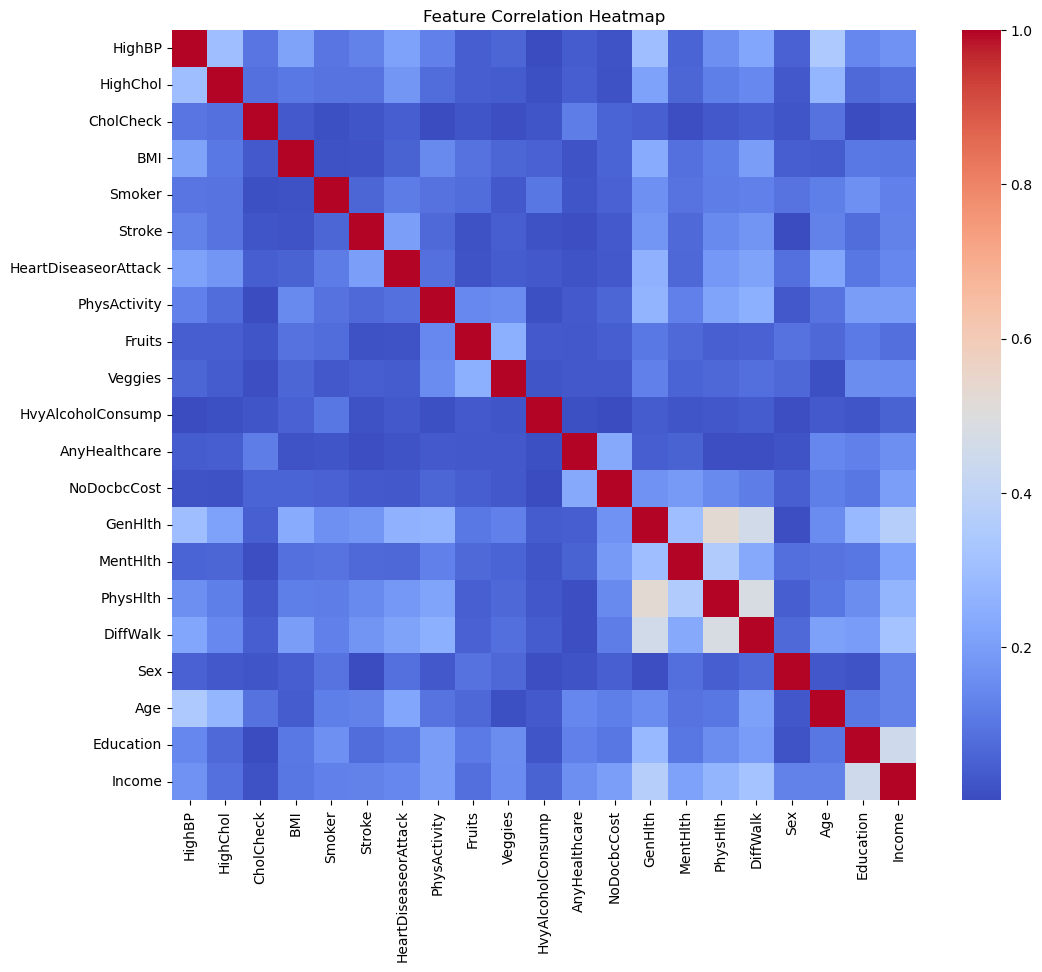

In [10]:
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title('Feature Correlation Heatmap')
plt.show()

<- no missing values

Remove higly correlated variables

In [11]:
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation > 0.9 (threshold is adjustable)
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

# Drop redundant features
X_reduced = X.drop(columns=to_drop)
print(f"Removed {len(to_drop)} highly correlated features: {to_drop}")

Removed 0 highly correlated features: []


Use mutual information filter methods to quantify the amount of information that one variable provides about another

In [12]:
selector = SelectKBest(score_func=mutual_info_classif, k=10)
X_new = selector.fit_transform(X, y)

Let's try backword stepwise elimination (with multinominal logistische regression)

In [13]:
import statsmodels.api as sm

#Add constant for intercept

X = sm.add_constant(X)

cols = list(X.columns)
pmax = 1
while len(cols) > 0:
    # Inside your while loop:
    model = sm.MNLogit(y, X[cols]).fit(disp=0)

    # Take max p-value per feature across classes
    p_values = model.pvalues
    p_values_max = p_values.max(axis=1)
    pmax = p_values_max.max()
    feature_with_p_max = p_values_max.idxmax()

    # Backward elimination step
    if pmax > 0.05:
        print(f"Dropping '{feature_with_p_max}' with p = {pmax:.4f}")
        cols.remove(feature_with_p_max)
    else:
        break

print(f"Selected features: {cols}")

Dropping 'PhysActivity' with p = 0.7308
Dropping 'DiffWalk' with p = 0.5998
Dropping 'Smoker' with p = 0.5562
Dropping 'HeartDiseaseorAttack' with p = 0.5250
Dropping 'Fruits' with p = 0.4939
Dropping 'AnyHealthcare' with p = 0.2242
Dropping 'NoDocbcCost' with p = 0.1240
Dropping 'Veggies' with p = 0.1182
Dropping 'Stroke' with p = 0.0915
Selected features: ['const', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'HvyAlcoholConsump', 'GenHlth', 'MentHlth', 'PhysHlth', 'Sex', 'Age', 'Education', 'Income']


### Outliers!!! -> needs to be included

In [14]:
#does Chol Check ever has a value 0? Then the patient would not been tested and HighChol would be NAN rather than the value there.
sum(data['CholCheck']==0) #but: 0 = no cholesterol check in 5 years 1 = yes cholesterol check in 5 years
#maybe they checked this value earlier than 5 years in past

9470

In [15]:
"""Another important command to be aware of is [`groupby()`]
(https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html), 
which allows you to apply a function or perform a computation for a particular view of a `DataFrame`. 
For example, if we want to compute the total number of children orphaned due to AIDS for every country, 
we can use the following command:

data_cleaned.groupby("Country")["Data.AIDS-Related Deaths.AIDS Orphans"].sum()"""

'Another important command to be aware of is [`groupby()`]\n(https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html), \nwhich allows you to apply a function or perform a computation for a particular view of a `DataFrame`. \nFor example, if we want to compute the total number of children orphaned due to AIDS for every country, \nwe can use the following command:\n\ndata_cleaned.groupby("Country")["Data.AIDS-Related Deaths.AIDS Orphans"].sum()'

### Data Visualisation

In [16]:
""" from Tutorial 2
sns.displot(
    x="Data.AIDS-Related Deaths.All Ages",
    data=data_cleaned
)
plt.show() """

' from Tutorial 2\nsns.displot(\n    x="Data.AIDS-Related Deaths.All Ages",\n    data=data_cleaned\n)\nplt.show() '